#**Extract dataset**

In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/EmotionRecognitionData.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done")

Done


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

#**Initializing Training and Test Generators**

In [4]:
train_dir = 'train'
val_dir = 'test'

train_img_datagen = ImageDataGenerator(rescale = 1./255)
val_img_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_img_datagen.flow_from_directory (
    train_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

val_set = val_img_datagen.flow_from_directory (
    val_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building the Convolutional Neural Network (CNN) Model**

In [5]:
base_model = tf.keras.applications.ResNet50(input_shape = (48, 48, 3), include_top = False, weights = "imagenet")

94781440/94765736 [==============================] - 2s 0us/step


In [6]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(
                32,
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (48, 48, 3),
                data_format = 'channels_last'))
model.add(Conv2D(
                64,
                kernel_size = (3, 3),
                padding = 'same',
                activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(
                128,
                kernel_size = (3, 3),
                padding = 'same',
                activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Conv2D(
                128,
                kernel_size = (3, 3),
                padding = 'same',
                activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [7]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(
                    learning_rate = 0.0001,
                    decay = 1e-6,
                    amsgrad = 'True'),
    metrics = ['accuracy'])

model_info = model.fit(
    train_set,
    steps_per_epoch = 449,
    epochs = 10,
    validation_data = val_set,
    validation_steps = 112)

Epoch 1/10
449/449 [==============================] - 61s 93ms/step - loss: 1.5973 - accuracy: 0.3553 - val_loss: 1.8540 - val_accuracy: 0.2174
Epoch 2/10
449/449 [==============================] - 41s 92ms/step - loss: 1.2538 - accuracy: 0.5326 - val_loss: 1.4299 - val_accuracy: 0.4821
Epoch 3/10
449/449 [==============================] - 40s 90ms/step - loss: 1.0058 - accuracy: 0.6270 - val_loss: 1.1953 - val_accuracy: 0.5672
Epoch 4/10
449/449 [==============================] - 41s 90ms/step - loss: 0.8069 - accuracy: 0.7094 - val_loss: 1.2180 - val_accuracy: 0.5760
Epoch 5/10
449/449 [==============================] - 43s 96ms/step - loss: 0.6193 - accuracy: 0.7800 - val_loss: 1.3077 - val_accuracy: 0.5883
Epoch 6/10
449/449 [==============================] - 40s 88ms/step - loss: 0.4564 - accuracy: 0.8424 - val_loss: 1.4233 - val_accuracy: 0.6009
Epoch 7/10
449/449 [==============================] - 40s 89ms/step - loss: 0.3440 - accuracy: 0.8869 - val_loss: 1.5768 - val_accuracy:

#**Saving and Loading the Model**

In [8]:
model.save('model.h5')

In [9]:
model = load_model('model.h5')

#**Capture using webcam**

In [10]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [11]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

#**Graphical representation**

In [12]:
def emotion_predict(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'suprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos,
            emotions,
            align = 'center',
            alpha = 0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()

In [13]:
def facecrop(image):  
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite('capture.jpg', sub_face)

    except Exception as e:
        print (e)

In [16]:
facecrop('/content/photo.jpg')

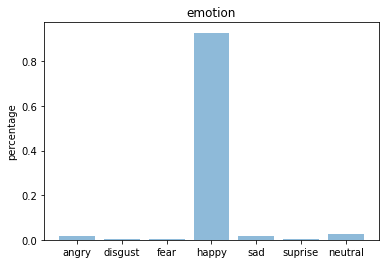

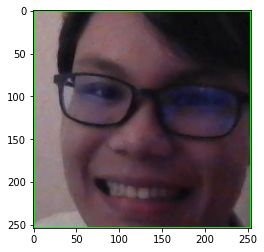

In [17]:
file = '/content/capture.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode = 'rgb', target_size = (48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_predict(custom[0])

x = np.array(x, 'float32')
x = x.reshape([1, 48, 48, 3])

plt.imshow(true_image)
plt.show()